In [1]:
# MNIST with an MLP, from scratch

# - Step 1: build an MLP from scratch to solve MNIST. Question set: https://fleuret.org/dlc/materials/dlc-practical-3.pdf
# - Step 2: debug your network with backprop ninja and a reference implementation using torch's .backward()
# - Step 3: build the same MLP but will full pytorch code (nn.Linear, etc.)

In [2]:
import math
import torch
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from utils import load_data

In [4]:
train_input, train_target, test_input, test_target = load_data(one_hot_labels = True, normalize = True)

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


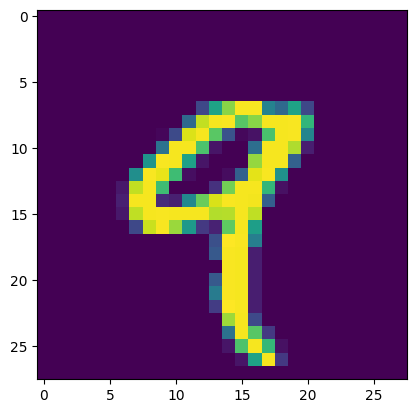

In [5]:
plt.imshow(train_input[4].view((28,28)))

In [6]:
def compute_accuracy (preds, targets):
    """ Computes the accuracy between predictions and targets. Data is expected to be one-hot encoded. """
    _, idx1 = torch.max(preds, dim=1)
    _, idx2 = torch.max(targets, dim=1)
    d = idx1 == idx2
    return d.int().float().mean().item()

In [29]:
# unit test
# this cell should return 0.75
preds = torch.zeros((4,7))
preds[0,1] = 1
preds[1,4] = 1
preds[2,2] = 1
preds[3,6] = 1
targets = torch.zeros((4,7))
targets[0,1] = 1
targets[1,4] = 1
targets[2,2] = 1
targets[3,2] = 1
compute_accuracy(preds, targets)

0.75

In [30]:
def sigma(x):
    return torch.tanh(x)

def dsigma(x):
    return 1 - torch.pow(sigma(x), 2)

In [32]:
def loss (v,t):
    return torch.sum(torch.pow(v-t, 2))

def dloss(v,t):
    return -2 * (t - v)

In [33]:
# sanity check
v = torch.randn((3, 6), dtype=torch.float32)
t = torch.randn((3, 6), dtype=torch.float32)
l=loss(v,t)
dloss(v,t)

tensor([[ 3.5529,  1.1427, -0.1610, -2.0885, -3.8716, -4.2020],
        [ 1.1891,  2.0751,  4.8847,  1.2422, -1.4316, -4.5210],
        [ 5.5198, -1.9320, -1.5009, -2.7508,  0.8101,  1.0077]])

In [34]:
# multiply targets by 0.9 to be in the range of tanh
train_target *= 0.9
test_target *= 0.9

### Step 1: Backprop ninja

In [35]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
# DO NOT MODIFY IT
#
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [36]:
torch.manual_seed(1337)
w1 = torch.randn((784, 50))
b1 = torch.randn((50))
w2 = torch.randn((50, 10))
b2 = torch.randn((10))
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad = True

In [37]:
x1 = train_input[:5]
y1 = train_target[:5]
z1 = x1@w1 + b1
h1 = sigma(z1)
z2 = h1@w2 + b2
h2 = sigma(z2)
l = loss(h2, y1)
h2.shape, l

(torch.Size([5, 10]), tensor(43.0514, grad_fn=<SumBackward0>))

In [38]:
# Force pytorch to retain grade for intermediate nodes and reset grad for parameters
# DO NOT MODIFY THIS CODE
#
others = [h2,z2,h1,z1]
for p in parameters:
    p.grad = None
for t in others:
    t.retain_grad()
l.backward()
print(f'loss={l}')

loss=43.05143356323242


In [39]:
b2.grad.shape

torch.Size([10])

In [40]:
# here we compare our gradient to the reference gradient computed by pytorch
dl = 1.0
dh2 = dloss(h2, y1)*dl
cmp('h2',dh2,h2)
dz2 = dsigma(z2)*dh2
cmp('z2',dz2, z2)
dw2 = h1.T @ dz2
cmp('w2',dw2, w2)
db2 = dz2.sum(axis=0, keepdim=True)
cmp('b2',db2, b2)
dh1 = dz2 @ w2.T
cmp('h1',dh1, h1)
dz1 = dsigma(z1)*dh1
cmp('z1', dz1, z1)
dw1 = x1.T @ dz1
cmp('w1', dw1, w1)
db1 = dz1.sum(axis=0, keepdim=True)
cmp('b1', db1, b1)


h2              | exact: True  | approximate: True  | maxdiff: 0.0
z2              | exact: True  | approximate: True  | maxdiff: 0.0
w2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
h1              | exact: True  | approximate: True  | maxdiff: 0.0
z1              | exact: True  | approximate: True  | maxdiff: 0.0
w1              | exact: True  | approximate: True  | maxdiff: 0.0
b1              | exact: True  | approximate: True  | maxdiff: 0.0


In [41]:
lr = 0.1
with torch.no_grad():
    w1 += -lr * dw1
    b1 += -lr * db1.squeeze()
    w2 += -lr * dw2
    b2 += -lr * db2.squeeze()

In [42]:
l = loss(h2, y1)
l.item()

43.05143356323242

##### Now that we've checked our gradients are correct, we can implement the network

In [43]:
def forward(w1, b1, w2, b2, x):
    z1 = x @ w1 + b1
    h1 = sigma(z1)
    z2 = h1 @ w2 + b2
    h2 = sigma(z2)
    return z1, h1, z2, h2


In [44]:
def backward(w1, b1, w2, b2, x1, y1, h2, z2, h1, z1):
    dl = 1.0
    dh2 = dloss(h2, y1)*dl
    dz2 = dsigma(z2)*dh2
    dw2 = h1.T @ dz2
    db2 = dz2.sum(axis=0, keepdim=True)
    dh1 = dz2 @ w2.T
    dz1 = dsigma(z1)*dh1
    dw1 = x1.T @ dz1
    db1 = dz1.sum(axis=0, keepdim=True)
    return dw1, db1, dw2, db2

In [45]:
def update(w1, b1, w2, b2, dw1, db1, dw2, db2, lr):
    with torch.no_grad():
        w1 += -lr * dw1
        b1 += -lr * db1.squeeze()
        w2 += -lr * dw2
        b2 += -lr * db2.squeeze()
    return w1, b1, w2, b2

In [47]:
def init():
    """ init a network """
    torch.manual_seed(1337)
    w1 = torch.randn((784, 50))
    b1 = torch.randn((50))
    w2 = torch.randn((50, 10))
    b2 = torch.randn((10))
    return w1, b1, w2, b2

In [48]:
w1, b1, w2, b2 = init()
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad_(True)

In [ ]:
# main training loop
torch.set_printoptions(linewidth=200)
def train(w1, b1, w2, b2):
    lossi = []
    for step in range(10000):
        xb = train_input
        yb = train_target
        num_samples = xb.shape[0]
        # forward
        z1, h1, z2, h2 = forward(w1, b1, w2, b2, xb)
        lsi = loss(h2, yb)
        # backward
        dw1, db1, dw2, db2 = backward(w1, b1, w2, b2, xb, yb, h2, z2, h1, z1)
        # update
        lr = 0.1 / num_samples if step < 5000 else 0.01 / num_samples
        w1, b1, w2, b2 = update(w1, b1, w2, b2, dw1, db1, dw2, db2, lr)
        if step % 100 == 0: print(f'step = {step}, loss = {lsi}')
        lossi.append(lsi.item())
    # compute accuracy
    _, _, _, preds = forward(w1, b1, w2, b2, train_input)
    train_accuracy = compute_accuracy(preds, train_target)
    _, _, _, preds = forward(w1, b1, w2, b2, test_input)
    test_accuracy = compute_accuracy(preds, test_target)
    print(f'{train_accuracy=}')
    print(f'{test_accuracy=}')
    return lossi
    

In [50]:
lossi = train(w1, b1, w2, b2)


step = 0, loss = 9579.4970703125
step = 100, loss = 8354.36328125
step = 200, loss = 7928.8896484375
step = 300, loss = 7747.337890625
step = 400, loss = 7509.19091796875
step = 500, loss = 7345.33837890625
step = 600, loss = 7159.6884765625
step = 700, loss = 7004.125
step = 800, loss = 6839.9365234375
step = 900, loss = 6708.9326171875
step = 1000, loss = 6585.35009765625
step = 1100, loss = 6452.56689453125
step = 1200, loss = 6309.578125
step = 1300, loss = 6167.9443359375
step = 1400, loss = 5904.8671875
step = 1500, loss = 5535.41650390625
step = 1600, loss = 5379.0654296875
step = 1700, loss = 5163.5869140625
step = 1800, loss = 4754.16796875
step = 1900, loss = 4156.76416015625
step = 2000, loss = 3227.5615234375
step = 2100, loss = 2407.86376953125
step = 2200, loss = 2100.87060546875
step = 2300, loss = 2037.5179443359375
step = 2400, loss = 1977.8067626953125
step = 2500, loss = 1907.9957275390625
step = 2600, loss = 1812.6607666015625
step = 2700, loss = 1657.4249267578125


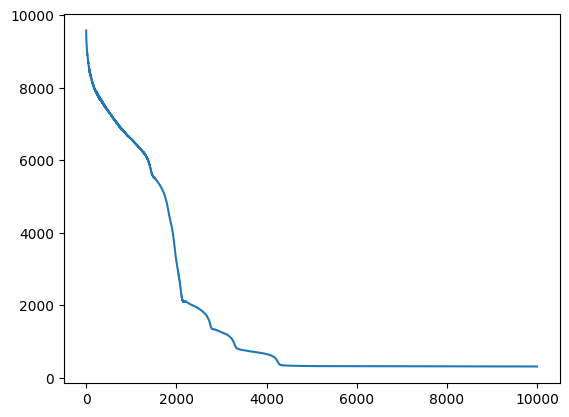

In [51]:
plt.plot(lossi)

### Step 2: Reference implementation using pytorch's .backward()
Nothing to do in Step 2, this code is provided for you as a reference

In [52]:
w1, b1, w2, b2 = init()
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad_(True)

In [53]:
# reference code
torch.set_printoptions(linewidth=200)
import torch.nn as F

def train(w1, b1, w2, b2):
    lossi = []
    for step in range(10000):
        xb = train_input
        yb = train_target
        num_samples = xb.shape[0]
        # forward
        z1, h1, z2, h2 = forward(w1, b1, w2, b2, xb)
        xloss = F.MSELoss()
        lsi = xloss(h2, yb) * yb.nelement()
        # backward
        for p in parameters:
            p.grad = None
        lsi.backward()
        # update
        lr = 0.1 / num_samples
        for p in parameters:
            p.data += -lr * p.grad
        if step % 100 == 0: print(f'step = {step}, loss = {lsi}')
        lossi.append(lsi.item())
    # compute accuracy
    _, _, _, preds = forward(w1, b1, w2, b2, train_input)
    train_accuracy = compute_accuracy(preds, train_target)
    _, _, _, preds = forward(w1, b1, w2, b2, test_input)
    test_accuracy = compute_accuracy(preds, test_target)
    print(f'{train_accuracy=}')
    print(f'{test_accuracy=}')
    return lossi

In [54]:
lossi = train(w1, b1, w2, b2)

step = 0, loss = 9579.4970703125
step = 100, loss = 8330.966796875
step = 200, loss = 7950.361328125
step = 300, loss = 7686.9521484375
step = 400, loss = 7498.69384765625
step = 500, loss = 7309.0751953125
step = 600, loss = 7151.49169921875
step = 700, loss = 6989.42724609375
step = 800, loss = 6855.2392578125
step = 900, loss = 6716.21044921875
step = 1000, loss = 6585.87353515625
step = 1100, loss = 6469.17529296875
step = 1200, loss = 6344.673828125
step = 1300, loss = 6162.0732421875
step = 1400, loss = 5893.0029296875
step = 1500, loss = 5463.6142578125
step = 1600, loss = 5285.91748046875
step = 1700, loss = 5025.7880859375
step = 1800, loss = 4523.64990234375
step = 1900, loss = 3951.326904296875
step = 2000, loss = 3016.418701171875
step = 2100, loss = 2128.29541015625
step = 2200, loss = 2076.780029296875
step = 2300, loss = 2020.0240478515625
step = 2400, loss = 1968.2037353515625
step = 2500, loss = 1904.3470458984375
step = 2600, loss = 1827.3873291015625
step = 2700, los

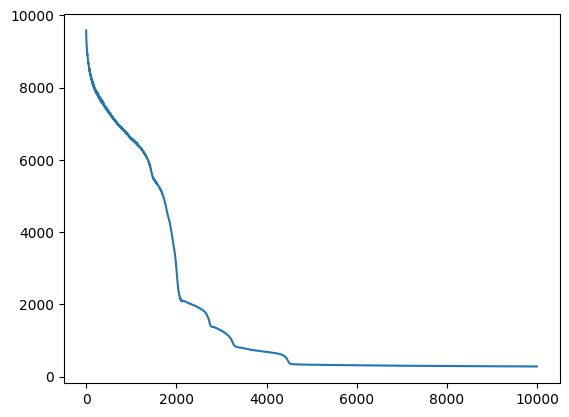

In [55]:
plt.plot(lossi)

### Step 3: Build the same MLP layer but with fully pytorch code (nn.Linear(), etc.)

In [56]:
# network dimensions
n_in = 784
n_hidden = 200
n_out = 10

In [57]:
X_tr, Y_tr = train_input, train_target
X_test, Y_test = test_input, test_target

In [74]:
class MLP(nn.Module):

    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()
        self.n_in = n_in
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.layers = nn.ModuleList((
            nn.Linear(self.n_in, self.n_hidden),
            nn.Tanh(),
            nn.Linear(self.n_hidden, self.n_out),
            nn.Tanh()
        ))

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def __parameters__(self):
        return [p for layer in self.layers for p in layer.parameters]

model = MLP(n_in = 784, n_hidden = 50, n_out = 10)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [75]:
X_tr.shape, Y_tr.shape

(torch.Size([1000, 784]), torch.Size([1000, 10]))

In [76]:
y_pred = model(X_tr)

In [78]:
# training
num_epochs = 10000

for n in range(num_epochs):
    y_pred = model(X_tr)
    loss = loss_fn(y_pred, Y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if n % 1000 == 0: 
        with torch.no_grad():
            # train accuracy
            acc_train = compute_accuracy(y_pred, Y_tr)
            # test accuracy
            y_test_preds = model(X_test)
            acc_test = compute_accuracy(y_test_preds, Y_test)
            print(f'step = {n:6d}\tloss={loss.item():.5f}\taccuracy (train, test): {acc_train:.5f}\t{acc_test:.5f}')


step =      0	loss=0.11173	accuracy (train, test): 0.14300	0.20100
step =   1000	loss=0.00041	accuracy (train, test): 1.00000	0.83400
step =   2000	loss=0.00009	accuracy (train, test): 1.00000	0.82800
step =   3000	loss=0.00012	accuracy (train, test): 1.00000	0.82000
step =   4000	loss=0.00002	accuracy (train, test): 1.00000	0.81900
step =   5000	loss=0.00006	accuracy (train, test): 1.00000	0.82100
step =   6000	loss=0.00004	accuracy (train, test): 1.00000	0.81900
step =   7000	loss=0.00001	accuracy (train, test): 1.00000	0.82000
step =   8000	loss=0.00004	accuracy (train, test): 1.00000	0.81800
step =   9000	loss=0.00003	accuracy (train, test): 1.00000	0.81600


##### Exercise: try to improve accuracy!

In [79]:
model = MLP(n_in = 784, n_hidden = 50, n_out = 10)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-1)
loss_fn = nn.MSELoss()

In [80]:
# training
num_epochs = 10000

for n in range(num_epochs):
    y_pred = model(X_tr)
    loss = loss_fn(y_pred, Y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if n % 1000 == 0: 
        with torch.no_grad():
            # train accuracy
            acc_train = compute_accuracy(y_pred, Y_tr)
            # test accuracy
            y_test_preds = model(X_test)
            acc_test = compute_accuracy(y_test_preds, Y_test)
            print(f'step = {n:6d}\tloss={loss.item():.5f}\taccuracy (train, test): {acc_train:.5f}\t{acc_test:.5f}')


step =      0	loss=0.12266	accuracy (train, test): 0.12500	0.09000
step =   1000	loss=1.06658	accuracy (train, test): 0.09900	0.11600
step =   2000	loss=1.03645	accuracy (train, test): 0.09700	0.08500
step =   3000	loss=1.07047	accuracy (train, test): 0.09700	0.08500
step =   4000	loss=0.96323	accuracy (train, test): 0.11600	0.12600
step =   5000	loss=0.99530	accuracy (train, test): 0.11600	0.12600
step =   6000	loss=1.12587	accuracy (train, test): 0.09700	0.08500
step =   7000	loss=1.16378	accuracy (train, test): 0.09700	0.08500
step =   8000	loss=1.00146	accuracy (train, test): 0.11600	0.12600
step =   9000	loss=1.00146	accuracy (train, test): 0.11600	0.12600
